<a href="https://colab.research.google.com/github/min02yam/R-study/blob/main/20220522_hotel_%ED%95%98%EB%8A%94%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------------------------------
## 호텔 예약 취소 고객 예측하기

본 데이터는 호텔 예약과 관련된 데이터입니다. 호텔, 고객, 예약과 관련된 정보들이 있습니다. 

**AUC가 높은 모델**을 만드는 것이 목표입니다.

### 1. 전처리
- 결측치가 있는 열을 찾아 최빈값으로 대체
- 연속형 변수 (numeric): normalization 실행 (scale, min-max scaling 등을 활용)
- 범주형 변수 (factor, character): label encoding 또는 one-hot encoding (dummy) 사용하여 전처리
    - label encoding: 문자형 변수를 숫자로 대체
    - one-hot encoding: 문자형 변수들을 0,1로 구성된 여러 개의 더미 변수들로 만들기
        - e.g. location (서울, 대전, 인천, 부산 ...) 변수 ⇒ location_서울, location_대전, location_인천 등
        - `fastDummies` 패키지 활용해보기

### 2. 모델링

- 원하는 모델을 사용하여 호텔 예약 취소 고객을 예측할 것
    - `set.seed(2022)` 사용
    - Train Test 비율: 7:3
    - Y: `is_canceled`
    - X: Y변수를 제외한 **모든 변수를 활용**
    - **예측 확률값**을 csv 파일로 제출하기
        - 모델링할 때 파라미터 또는 `predict( )` 사용 시 확률값 출력 가능
    - 가장 높은 AUC를 달성한 분께는 **스타벅스 기프티콘**


--------------------------------------------------------------------------


# 1. 데이터 로드 및 간단 구조 확인

In [68]:
#install.packages(c("DataExplorer","fastDummies","tidyquant","tidyverse"))
install.packages("superml") #label encoder

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Metrics’




In [69]:
#library(dplyr) ; library(reshape2)
#library(DataExplorer); library(fastDummies) ; library(tidyquant); library(tidyverse)  
library(superml)

Loading required package: R6



In [117]:
df<-read.csv("/content/hotel.csv") 

In [5]:
str(df); summary(df)

'data.frame':	119390 obs. of  17 variables:
 $ hotel_type                    : chr  "Resort Hotel" "Resort Hotel" "Resort Hotel" "Resort Hotel" ...
 $ is_canceled                   : int  0 0 0 0 0 0 0 0 1 1 ...
 $ lead_time                     : int  342 737 7 13 14 14 0 9 85 75 ...
 $ stays_in_weekend_nights       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stays_in_week_nights          : int  0 0 1 1 2 2 2 2 3 3 ...
 $ adults                        : int  2 2 1 1 2 2 2 2 2 2 ...
 $ children                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ babies                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ meal                          : chr  "BB" "BB" "BB" "BB" ...
 $ is_repeated_guest             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ previous_cancellations        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ previous_bookings_not_canceled: int  0 0 0 0 0 0 0 0 0 0 ...
 $ reserved_room_type            : chr  "C" "C" "A" "A" ...
 $ assigned_room_type            : chr  "C" "C" "C" "A" ...
 $ booking_changes 

  hotel_type         is_canceled       lead_time   stays_in_weekend_nights
 Length:119390      Min.   :0.0000   Min.   :  0   Min.   : 0.0000        
 Class :character   1st Qu.:0.0000   1st Qu.: 18   1st Qu.: 0.0000        
 Mode  :character   Median :0.0000   Median : 69   Median : 1.0000        
                    Mean   :0.3704   Mean   :104   Mean   : 0.9276        
                    3rd Qu.:1.0000   3rd Qu.:160   3rd Qu.: 2.0000        
                    Max.   :1.0000   Max.   :737   Max.   :19.0000        
                                                                          
 stays_in_week_nights     adults          children           babies         
 Min.   : 0.0         Min.   : 0.000   Min.   : 0.0000   Min.   : 0.000000  
 1st Qu.: 1.0         1st Qu.: 2.000   1st Qu.: 0.0000   1st Qu.: 0.000000  
 Median : 2.0         Median : 2.000   Median : 0.0000   Median : 0.000000  
 Mean   : 2.5         Mean   : 1.856   Mean   : 0.1039   Mean   : 0.007949  
 3rd Qu.: 3.0  

In [119]:
#문자형->팩터변경
#df %<>% mutate(is_canceled = as.factor(is_canceled)) 
for (j in c(1:2,9,13:14)){
  df[,j]<-as.factor(df[,j])
}


1. 범주형 4, 연속형 12, 타겟1은 이진분류
2. 분포를 더 살펴 보아야 알겠지만, 변수 명세서를 봤을 때 어른의 수(adults), 취소되지 않은 예약 횟수, 호텔 평균 가격(adr) 등 포텐셜 아웃라이어로 예상되는 값이 존재한다<br> ⏩문제에 해당된 전처리만 한다면 아웃라이어에 민감하지 않은 모델을 선택해야 한다.
3. children에 NA 4개 존재
4. 스케일링 필요

# 2. Basic EDA

1) 인트로

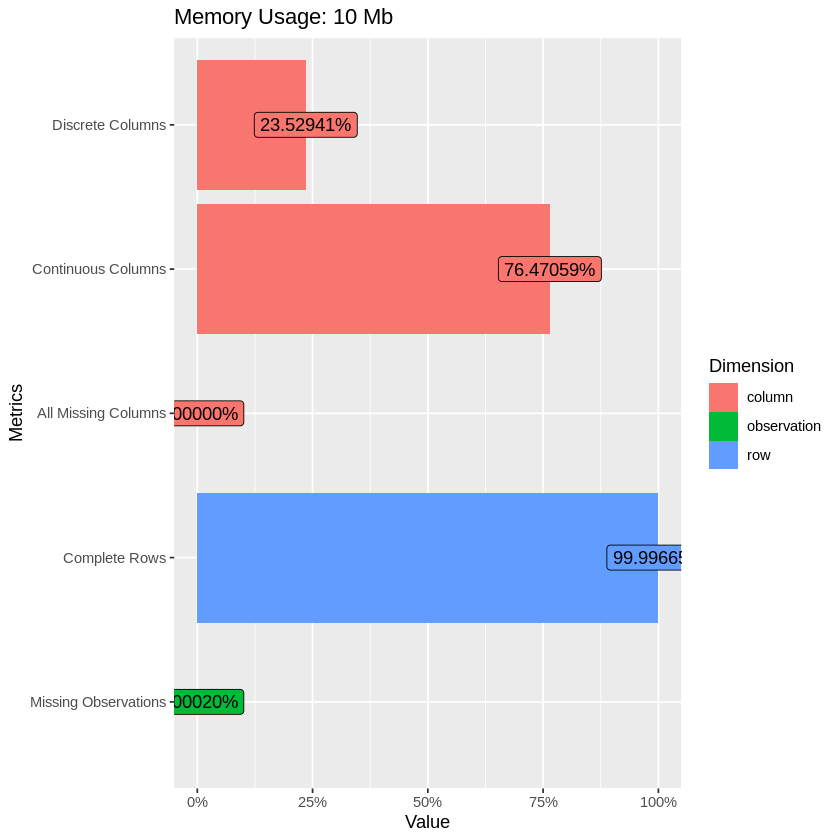

In [6]:
plot_intro(df)

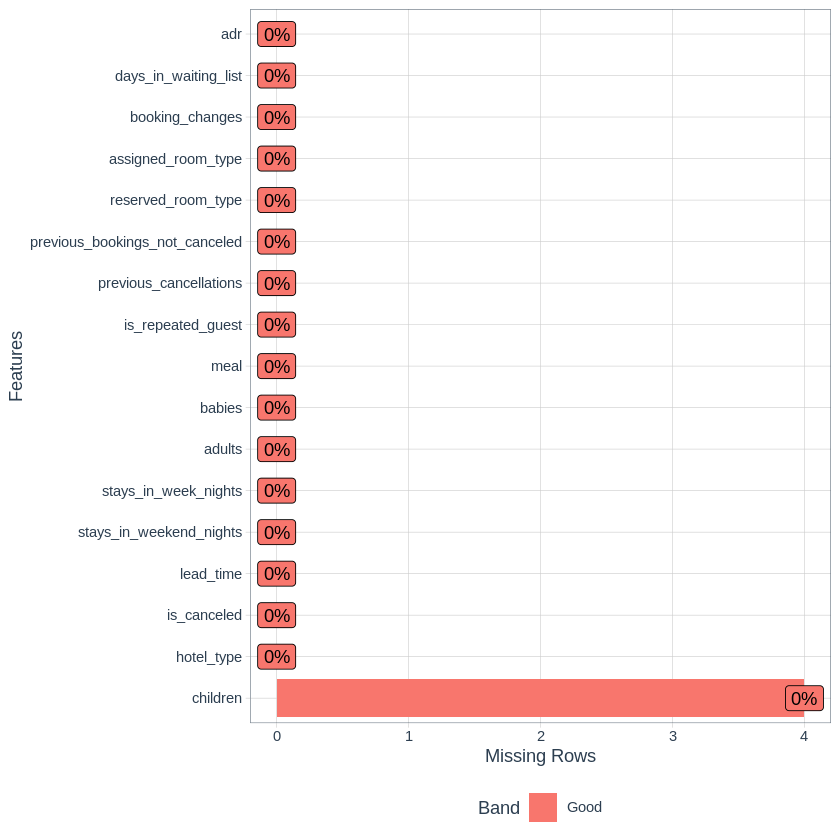

In [7]:
plot_missing(df, ggtheme = theme_tq())

* 앞서 확인한 것과 같음

In [ ]:
library(magrittr) #파이프

2) 범주형

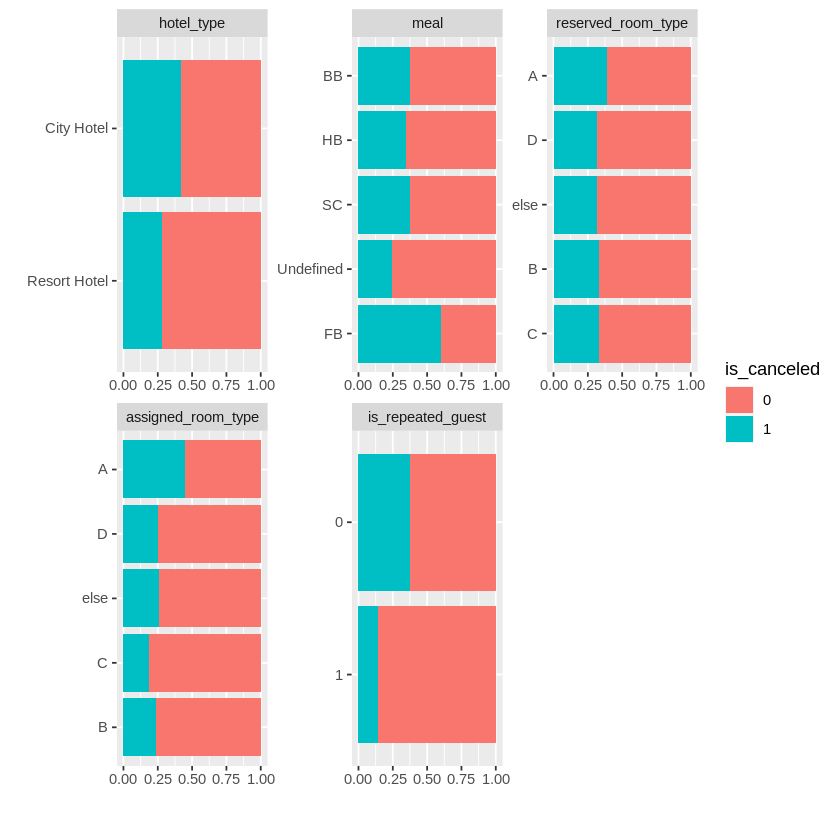

In [10]:
plot_bar(df, by ='is_canceled') 

- 예약 객실 유형(reserved_room_type)과 배정된 객실 유형(assigned_room_type)은 타겟에 대한 분포가 비슷하다
- A / D+ELSE/ C+D로 범주 재조정 할 예정 왜냐하면 그냥 삼차원 그래프 만들어 보고 싶어서
- city hotel이 resort hotel과 비교하여 취소율이 높음
- meal에선 FB가 눈에 띄게 취소율이 높음 FB가 뭘까
- 방 타잎은  A가 제일 높고
- 재방문한 손님은 취소율이 낮다.

#### ~~범주 재조정한거(안씀)~~

In [11]:
df %<>% mutate(reserved_room_type = case_when(reserved_room_type=='A' ~ 'A',
                                    reserved_room_type == 'D' ~ 'D_else',
                                    reserved_room_type == 'else' ~ 'D_else',
                                    reserved_room_type=='B' ~ 'B_C',
                                    reserved_room_type=='C' ~ 'B_C' ,
                                    ) %>%as.factor) 

In [12]:
df %<>% mutate(assigned_room_type = case_when(assigned_room_type=='A' ~ 'A',
                                    assigned_room_type == 'D' ~ 'D_else',
                                    assigned_room_type == 'else' ~ 'D_else',
                                    assigned_room_type=='B' ~ 'B_C',
                                    assigned_room_type=='C' ~ 'B_C' ,
                                    ) %>%as.factor) 

In [13]:
str(df) # 확인

'data.frame':	119390 obs. of  17 variables:
 $ hotel_type                    : Factor w/ 2 levels "City Hotel","Resort Hotel": 2 2 2 2 2 2 2 2 2 2 ...
 $ is_canceled                   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 2 2 ...
 $ lead_time                     : int  342 737 7 13 14 14 0 9 85 75 ...
 $ stays_in_weekend_nights       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stays_in_week_nights          : int  0 0 1 1 2 2 2 2 3 3 ...
 $ adults                        : int  2 2 1 1 2 2 2 2 2 2 ...
 $ children                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ babies                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ meal                          : Factor w/ 5 levels "BB","FB","HB",..: 1 1 1 1 1 1 1 2 1 3 ...
 $ is_repeated_guest             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ previous_cancellations        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ previous_bookings_not_canceled: int  0 0 0 0 0 0 0 0 0 0 ...
 $ reserved_room_type            : Factor w/ 3 levels "A","B_C","D_else": 2 2 1 

In [14]:
#write.csv(df,"hotel2.csv", row.names=FALSE)  # 일단저장 gui에서해봄

In [15]:
install.packages("rgl") ;library(rgl)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNULL = TRUE'.”


In [16]:
mycolors <- c('royalblue1', 'darkcyan', 'oldlace')
df$color <- mycolors[ as.numeric(df$reserved_room_type) ]

In [17]:
df$children<-ifelse(is.na(df$children),0, df$children) #일단지움

In [18]:
#느릴까봐 샘플링
ind<-sample(1:nrow(df), nrow(df)*0.009, replace=F)
df_sample<-df[ind,]  

In [ ]:
setupKnitr()
plot3d( 
  x=df_sample$`adults`, y=df_sample$`children`, z=df_sample$`babies`, 
  col =df_sample$color, 
  type = 's', 
  radius = .1,
  xlab="adults", ylab="children", zlab="babies")   #GUI에서는됨
 
rglwidget()

## 다시 여기부터

3) 연속형

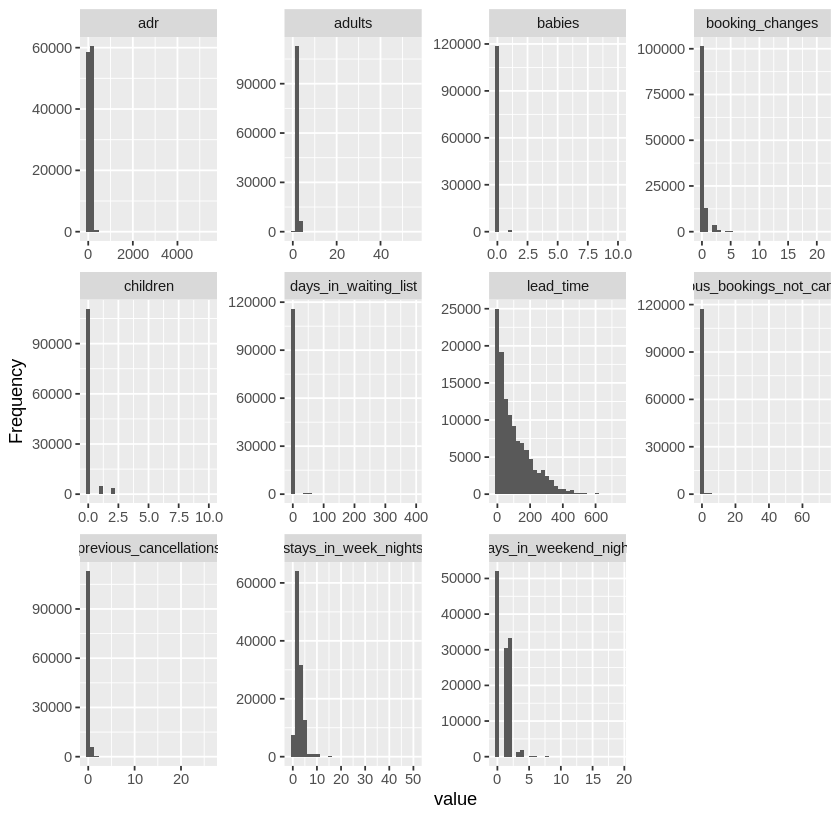

In [22]:
#df<-read.csv("/content/hotel.csv") 
plot_histogram(df)

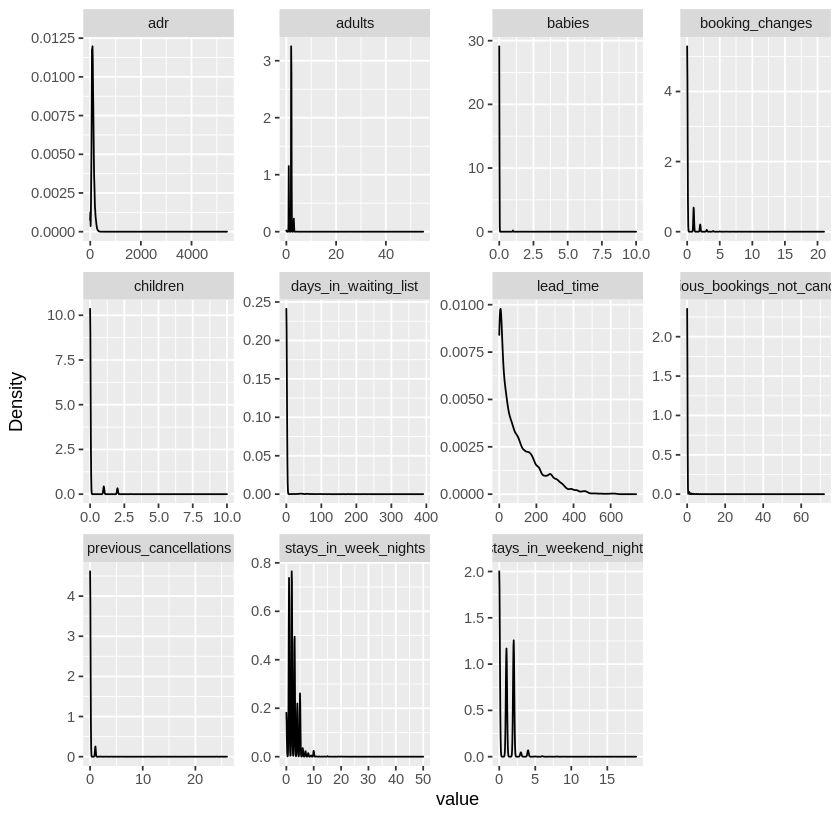

In [23]:
plot_density(df)

앞서 생각했던 변수 말고 대부분 변수에 아웃라이어 존재하는듯 

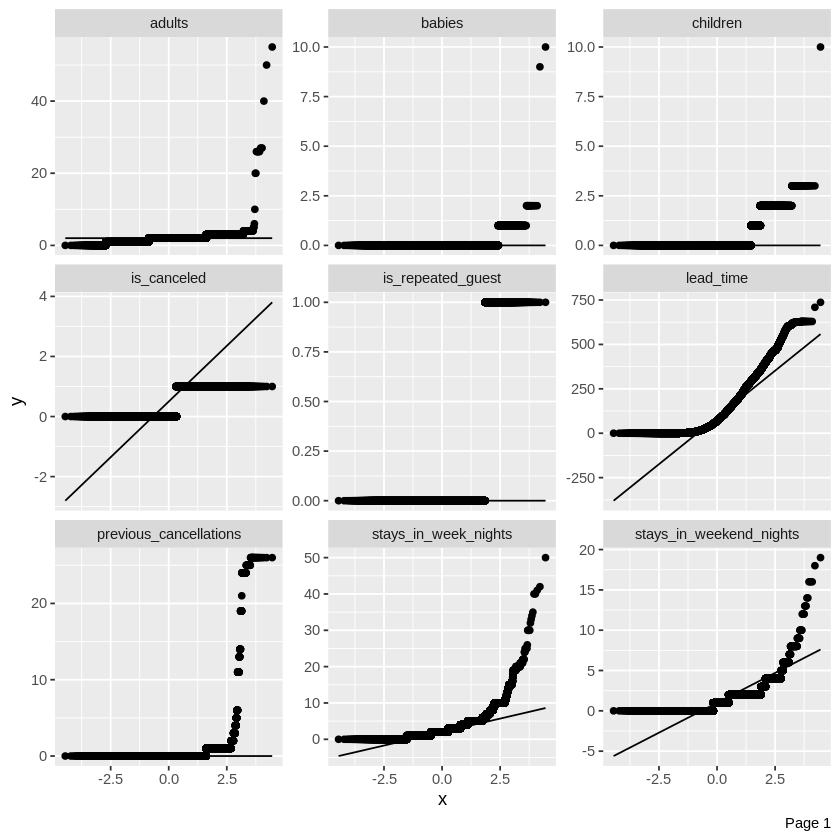

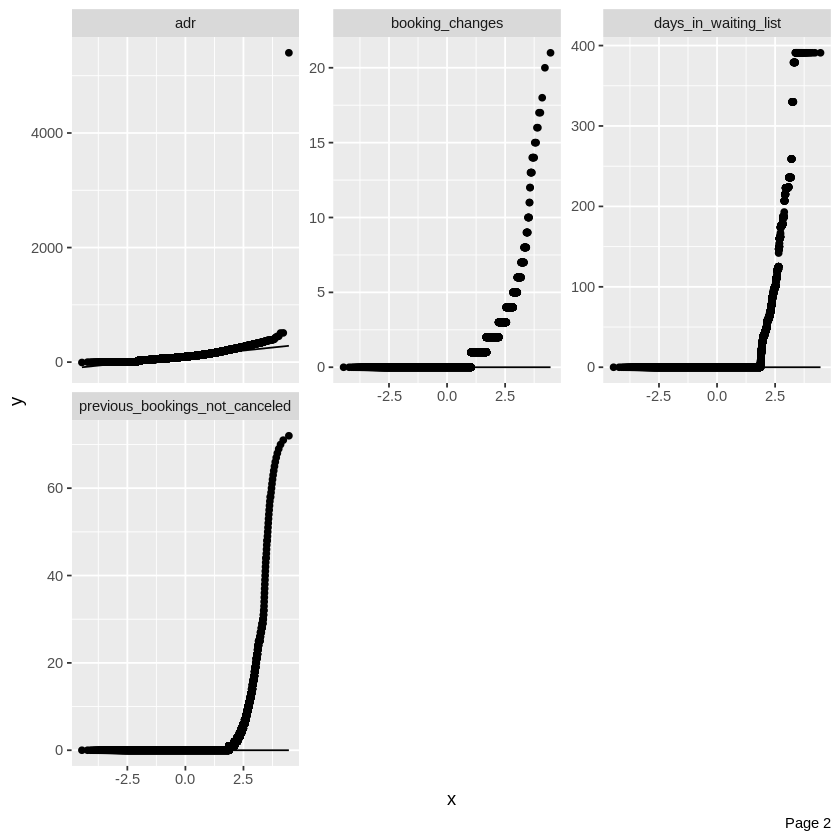

In [24]:
plot_qq(na.omit(df))

- discrete 피처를 제외하고 
- adr(가격관련된거)는 아웃라이어 제거하면 정규성 만족할듯
- 시간 관련된것도 만족할듯

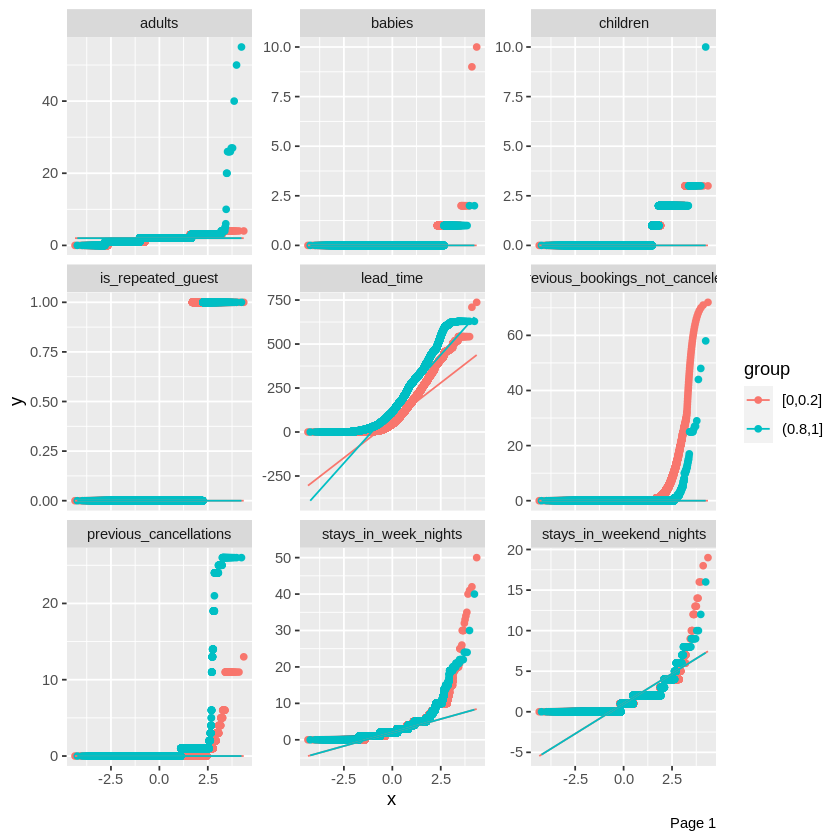

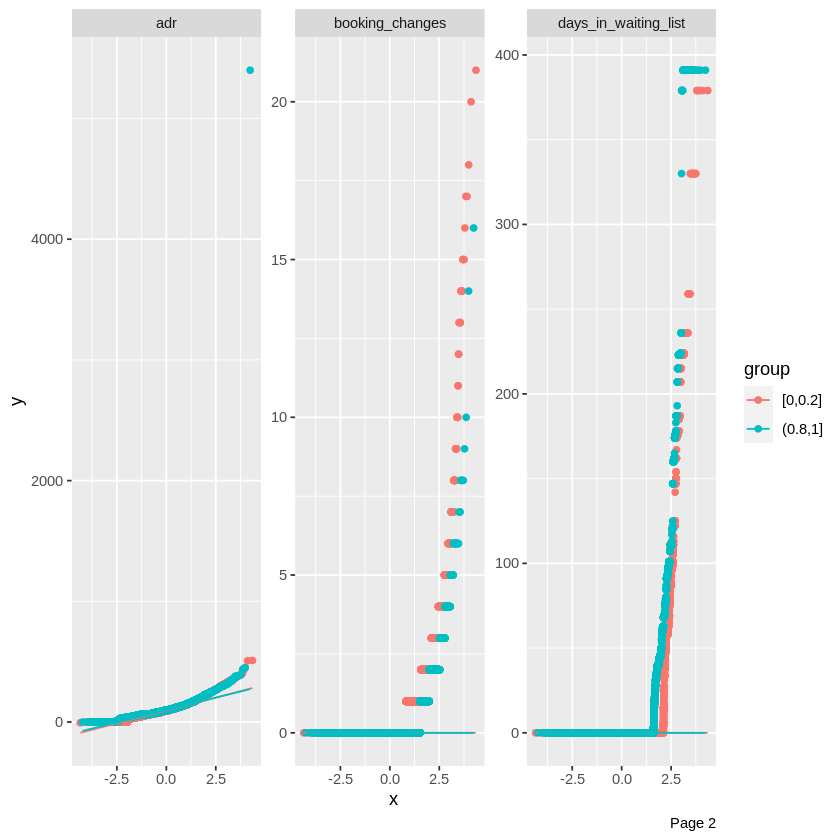

In [25]:
plot_qq(na.omit(df), by="is_canceled")

1. 어른 뿐만 아니라 아기와 어린이도 포텐셜 아웃라이어가 존재하는 것 같당
2. 예약 이후 호텔 이용까지의 기간의 median은 취소 안한경우가 더 높았다 이건좀 신기
3. 예전에 취소하면-> 취소하고, 취소 안하면 -> 취소 안하고 ,, 이건 좀 매우 당연
4. 주중 주말 포함 투숙 기간이 긴 경우 많이 취소함

Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”


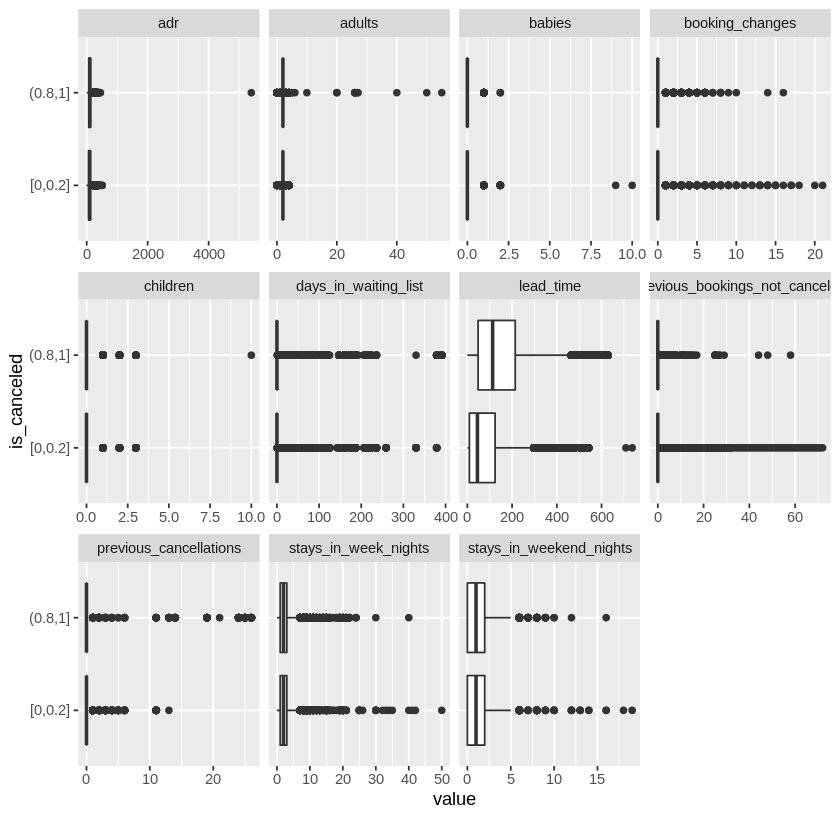

In [26]:
plot_boxplot(df, by = "is_canceled")

딴건 아웃라이어 때매 잘 모르겠고 lead_time이 타겟에 영향을 주긴 하는 것 같음 

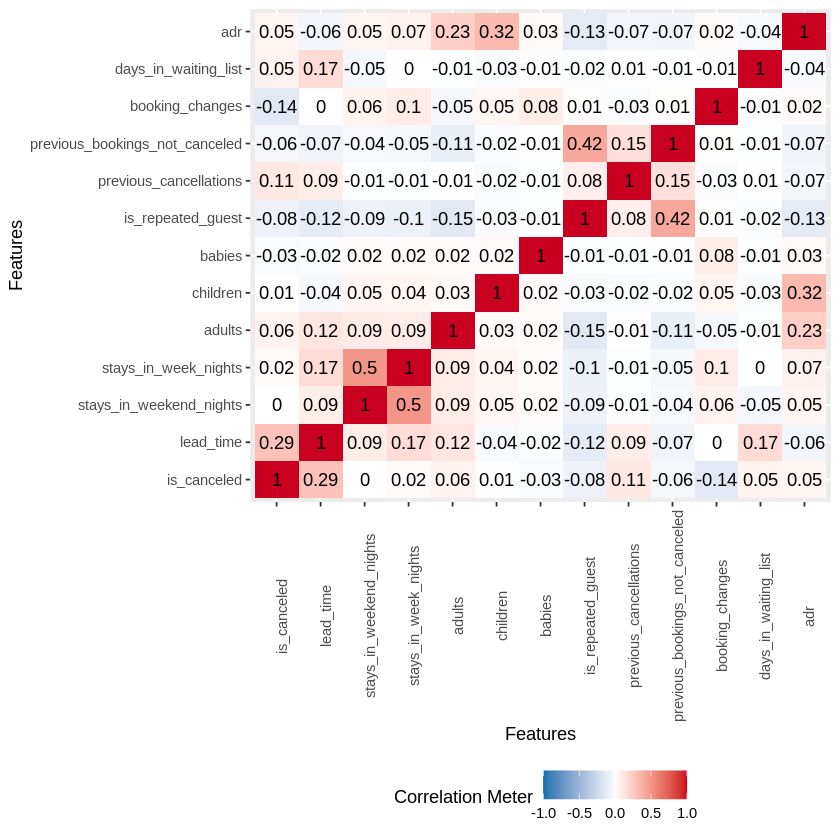

In [27]:
df %>% select_if(is.numeric) -> df_numeric
plot_correlation(na.omit(df_numeric))

딱히~ 아웃라이어 때문일지도

In [ ]:
#df_melt<-melt(  df , id.vars="is.canceled")

# 3. 전처리

1) 임퓨테이션
- 최빈값으로 대체

In [120]:
#df[which.max(df$children),"children"]
df$children<-ifelse(is.na(df$children), df[which.max(df$children),"children"],  df$children )

In [121]:
sum(is.na(df)) # 확인

[1] 0

3) 범주형피처

- one-hot encoding (dummy) -> 이진클래스(hotel_type, is_repeated_guest)
- label encoding -> 나머지 (meal9, 룸관련 두개13,14)


In [122]:
#라벨인코딩
lb_encoder = LabelEncoder$new() #라벨인코더 

for (j in c(9,13:14)){
  df[,j]<- lb_encoder$fit_transform(df[,j])
} 

In [125]:
#원핫인코딩
df<-dummy_cols( .data= df   , select_columns=c("hotel_type","is_repeated_guest") , remove_first_dummy=  FALSE, remove_selected_columns=TRUE )

2) 연속형피처
- 이상치가 보이므로 민맥스말고 표준화함

In [127]:
#함수생성
standard_scale<- function(x){
  (x - mean(x)) / sd(x)
  }

In [128]:
df %<>% mutate(across(where(is.numeric), ~ standard_scale(.x)))

In [129]:
df%>%head(3) 

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,days_in_waiting_list,adr,hotel_type_City Hotel,hotel_type_Resort Hotel,is_repeated_guest_0,is_repeated_guest_1
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,2.2270418,-0.9288865,-1.3102344,0.2478962,-0.2588389,-0.08157892,-0.5200661,-0.1031791,-0.09155438,0.7190480,0.4873113,4.2600831,-0.131923,-2.0150298,-1.407218,1.407218,0.1815596,-0.1815596
2,0,5.9233599,-0.9288865,-1.3102344,0.2478962,-0.2588389,-0.08157892,-0.5200661,-0.1031791,-0.09155438,0.7190480,0.4873113,5.7931070,-0.131923,-2.0150298,-1.407218,1.407218,0.1815596,-0.1815596
3,0,-0.9078103,-0.9288865,-0.7862039,-1.4784413,-0.2588389,-0.08157892,-0.5200661,-0.1031791,-0.09155438,-0.6056002,0.4873113,-0.3389884,-0.131923,-0.5309331,-1.407218,1.407218,0.1815596,-0.1815596


In [131]:
summary(df)

 is_canceled   lead_time       stays_in_weekend_nights stays_in_week_nights
 0:75166     Min.   :-0.9733   Min.   :-0.9289         Min.   :-1.3102     
 1:44224     1st Qu.:-0.8049   1st Qu.:-0.9289         1st Qu.:-0.7862     
             Median :-0.3276   Median : 0.0725         Median :-0.2622     
             Mean   : 0.0000   Mean   : 0.0000         Mean   : 0.0000     
             3rd Qu.: 0.5239   3rd Qu.: 1.0739         3rd Qu.: 0.2619     
             Max.   : 5.9234   Max.   :18.0975         Max.   :24.8913     
     adults           children           babies               meal        
 Min.   :-3.2048   Min.   :-0.2588   Min.   : -0.08158   Min.   :-0.5201  
 1st Qu.: 0.2479   1st Qu.:-0.2588   1st Qu.: -0.08158   1st Qu.:-0.5201  
 Median : 0.2479   Median :-0.2588   Median : -0.08158   Median :-0.5201  
 Mean   : 0.0000   Mean   : 0.0000   Mean   :  0.00000   Mean   : 0.0000  
 3rd Qu.: 0.2479   3rd Qu.:-0.2588   3rd Qu.: -0.08158   3rd Qu.:-0.5201  
 Max.   :91.7438  

ㅋㅋㅋ... 이상치 그대로 둘려고 표준화했는데 어이없을무 

#4. 모델링

1) 트레인 테스트 스플릿

In [ ]:
#set.seed(2022)

2) 피팅

3) 파라미터 튜닝

4) 평가

5) 저장